# Module 2 Final Project - How Does Discount Impact Sales? 


### Northwind Database

<img src='Northwind_ERD.png'>


## The Deliverables

The goal of your project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_**

In addition to answering this question with a hypothesis test, you will also need to come up with **_at least 3 other hypotheses to test on your own_**.  These can by anything that you think could be imporant information for the company. 

For this hypothesis, be sure to specify both the **_null hypothesis_** and the **_alternative hypothesis_** for your question.  You should also specify if this is one-tail or a two-tail test. 



In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pylab
%matplotlib inline

from IPython.display import display, HTML

from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.stats.api as sms
from statsmodels.regression.linear_model import OLSResults
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.formula.api as smf
import category_encoders as ce
from statsmodels.stats.power import TTestIndPower, FTestPower, FTestAnovaPower
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats.mstats import gmean

from patsy.contrasts import Sum
from patsy.contrasts import Helmert
from patsy.contrasts import Treatment
from patsy import dmatrices


In [2]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for col in cols_list:
        print("Name: {} \t Type: {}".format(col['name'], col['type']))
        
def z_hbar(data, y_col, x_col, xlabel, title):
    colors = sns.color_palette("GnBu_d", 10)
    plt.figure(figsize=(8,7))
    ax = sns.barplot(y = data[y_col], x = data[x_col], data=data, orient='h', palette=colors, errwidth=0.8,
           capsize=0.2)
    ax.set_xlabel(xlabel=xlabel, fontsize=14)
    ax.set_xticks(np.arange(-0.5, 1.5))
    ax.set_ylabel(ylabel='Participants', fontsize=14)
    ax.set_title(label=title, fontsize=17)
    plt.tight_layout();
    
def boxplot(data, x, y, xlabel, ylabel, title):
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
    fig, axes = plt.subplots(1, figsize=(9,6))
    sns.boxplot(x=x, y=y, data=data, ax=axes, palette=("husl"), boxprops=dict(alpha=.8), 
                showmeans=True, meanprops=meanpointprops)
    sns.swarmplot(x=x, y=y, data=data, color="grey", alpha=0.6)
    plt.xticks(fontsize=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14);
    
# Test for power based on sample and expected effect size
def power(df_num, df_denom, alpha, effect):
    return FTestPower().solve_power(effect_size=effect, df_num=df_num, df_denom=df_denom, alpha=alpha)

In [3]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=False)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)
con = engine.connect()
metadata = MetaData()

## What factors are related to increased sales and quantity?

- Assess discount for:
    * Discount vs Employee
    * Dicount vs Product
    * Discount vs Region
    * Discount vs Customer
    
- Take into consideration:
    * Hypotheses, FDR, power, beta, alpha
    * Interactions
    * Assumptions ANOVA (is using regression more robust?)
    * Effect sizes and estimated cost impacts

### DISCOUNT & QUANTITY

In [4]:
# Get names of tables in database
inspector.get_table_names()

['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [5]:
get_columns_info('Product')
print('\n')
get_columns_info('OrderDetail')
print('\n')
get_columns_info('Category')
print('\n')
get_columns_info('Order')

Table Name: Product

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER


Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


Table Name: Category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)


Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: D

In [6]:
product = pd.read_sql_query("""
SELECT o.EmployeeId, o.ShipRegion, od.Quantity, od.Discount, od.UnitPrice, o.Freight, 
        c.Id as CategoryId, c.CategoryName, ((p.UnitPrice * od.Quantity * (1 - od.Discount)) - Freight) as Revenue, 
        (p.UnitPrice * od.Quantity) as SalePrice
       
FROM [Order] o
    join OrderDetail od
    on od.OrderID = o.ID
    
    JOIN Product p
    on od.ProductID = p.ID
    
    JOIN Category c 
    on c.ID = p.CategoryID  

""", engine)              


In [7]:
# No missing data apparent
product.isna().sum();

# The Data

## Discount

The figure below shows that Discount is primarily categorical. Therefore, it was binned into a Binary variable and into a more granulated Group variable (ordinal, with bins of 5%) for analysis. 

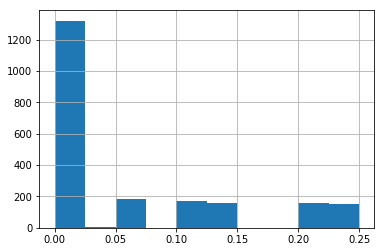

In [8]:
product.Discount.hist();

In [9]:
# Binary Discount 
product.loc[product['Discount'] == 0.0, 'DiscountBinary'] = 0
product.loc[product['Discount'] > 0.0, 'DiscountBinary'] = 1

# Binned Groups of 5%
product.loc[product['Discount'] == 0.0, 'DiscountGrouped'] = 0
product.loc[(product['Discount'] > 0.0) & (product['Discount'] <= 0.05), 'DiscountGrouped'] = 1
product.loc[(product['Discount'] > 0.05) & (product['Discount'] <= 0.10), 'DiscountGrouped'] = 2
product.loc[(product['Discount'] > 0.10) & (product['Discount'] <= 0.15), 'DiscountGrouped'] = 3
product.loc[(product['Discount'] > 0.15) & (product['Discount'] <= 0.20), 'DiscountGrouped'] = 4
product.loc[(product['Discount'] > 0.20) & (product['Discount'] <= 0.25), 'DiscountGrouped'] = 5

## Sales Price

The outcome variable of for the stated hypothesis is Quantity. 

However, to further evaluate whether:

i) Offering discounts benefits sales
ii) What level of discount best benefits sales

It is preferable to use Sales Price as the outcome variable. Sales Price was feature engineered from **Unit Price * Quantity**, and therefore contains information about quantity as well as overall value of the sale. This may therefore be a more informative metric for decision making with regards to what discount to offer customers in the future. 

Since Sales was positively skewed it was log transformed for more reliable analysis. 

/Users/danyalwainstein1/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


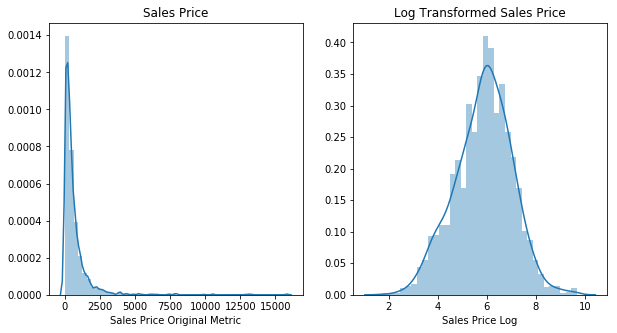

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

sns.distplot(product.SalePrice, ax=ax1)
sns.distplot(np.log(product.SalePrice), ax=ax2);

ax1.set_title('Sales Price')
ax2.set_title('Log Transformed Sales Price')

#ax1.xaxis.label.set_visible(False)
ax1.xaxis.set_label_text('Sales Price Original Metric')
ax2.xaxis.set_label_text('Sales Price Log')

product['LogSales'] = np.log(product.SalePrice)

In [24]:
product.SalePrice.describe().round(2)

count     2155.00
mean       672.56
std       1110.26
min          6.00
25%        170.50
50%        380.00
75%        760.00
max      15810.00
Name: SalePrice, dtype: float64

In [25]:
product.head()

,EmployeeId,ShipRegion,Quantity,Discount,UnitPrice,Freight,CategoryId,CategoryName,Revenue,SalePrice,DiscountBinary,DiscountGrouped,LogSales
0,5,Western Europe,12,0.0,14.0,32.38,4,Dairy Products,219.62,252.00,0.0,0.0,5.529429
1,5,Western Europe,10,0.0,9.8,32.38,5,Grains/Cereals,107.62,140.00,0.0,0.0,4.941642
2,5,Western Europe,5,0.0,34.8,32.38,4,Dairy Products,141.62,174.00,0.0,0.0,5.159055
3,6,Western Europe,9,0.0,18.6,11.61,7,Produce,197.64,209.25,0.0,0.0,5.343530
4,6,Western Europe,40,0.0,42.4,11.61,7,Produce,2108.39,2120.00,0.0,0.0,7.659171


# Significance Testing and Log Sales

Sales Price was log transformed and the logarithmic mean for significance testing. If we convert the logarithmic mean back into our original scale, we create Geometric Means, which are the anti-logs of the mean of the logged data. 

Since logarithmic transformation creates a more symmetric distribution where the mean and median coincide (as opposed to the original, where the median is less than the mean), an estimate of the log mean is also an estimate of the log median. Since the mean of the logs estimates the median of the logs, its anti-log--the geometric mean--estimates the median in the original scale. 

Therefore, interpreting the null based on a log transformed outcomes variable will result in an interpretation of the conditional median in the original data, rather than the mean. Furthermore, the coefficients must be interpreted as ratios rather than differences, when converted back into the original metric. 

The exponentiated coefficient can be interpreted as the ratio of the expected geometric mean for the one group compared with the expected geometric mean of the group it is being compared with. Marginal changes in the explanatory variables are interpreted in terms of multiplicative (percentage) changes in the dependent variable. 

In [13]:
# Functions for finding the Geometric Mean from Regression Models
def geo_mean_convert(B):
    # natural log of the input
    # exponentiation is inverse of logarithm 
    return round(np.exp(B), 2)

def geomean_ratio(coefficient, ref, group):
    # ratios of the natural logs
    ratio = round(np.exp(coefficient), 2)
    print('The geometric mean of {} is {} times {}'.format(group.title(), ratio, ref.title()))
    if ratio > 1:
          print('The geometric mean of {} is {}% more than {}'.format(group.title(), round(ratio%1*100, 0), ref.title()))      
    else:
          print('The geometric mean of {} is {}% less than {}'.format(group.title(), round((1 - ratio%1)*100, 2), ref.title()))
      
#def ci_geometric_ratio(lower, upper):
                
def geo_means(data, x, y):
    groups = sorted(list(data[x].unique()))
    geo_mean = [round(gmean(data.loc[data[x] == group][y]), 2) for group in groups]
    median = [round((data.loc[data[x] == group][y].median()), 2) for group in groups] 
    amean = [round(data.loc[data[x] == group][y].mean(), 2) for group in groups]
    df = pd.DataFrame({x:groups, 'geo_mean': geo_mean, 'median': median, 'mean': amean})
    return df

# QUANTITY 

**Hypotheses:**

$H_0$: **Discount does not significantly affect Sale Quantity (Discount = No Discount)**

$H_1$: **Discount does significantly affect Sale Quantity (Discount != No Discount)**


Various OLS models were used to study the relationships between quantity, discount and sales. In most instances the models are not complete and the aim was not overall predictive accuracy, but rather establishing relationships (or lack thereof) between variables. Since the F-test of the OLS model is identical to ANOVA, OLS was preferred for it's enhanced flexibility (ability to combine categorical and continuous variables), improved robustness and better diagnostic/influence tests. 

*NOTE: Transformed Y was only retained where transformation changed significance values. Since the sample size is large it was often the case that log/ sqrt transformed Y did not impact the conclusions and in this case the original variables were retained for interpretable coefficients.*  

/Users/danyalwainstein1/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    2155.000000
mean       23.812993
std        19.022047
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64


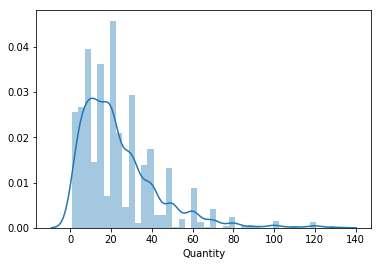

In [27]:
sns.distplot(product.Quantity)
print(product.Quantity.describe())

In [14]:
print('Quantity')
print(product.groupby(['DiscountGrouped'])['Quantity'].agg(['mean', 'std']).round(3))

                     Quantity
                   mean     std
DiscountGrouped                
0.0              21.715  17.507
1.0              27.052  22.331
2.0              25.103  21.199
3.0              28.382  20.923
4.0              27.025  18.833
5.0              28.240  20.121


In [15]:
product.groupby(['DiscountBinary'])['Quantity'].mean()

DiscountBinary
0.0    21.715262
1.0    27.109785
Name: Quantity, dtype: float64

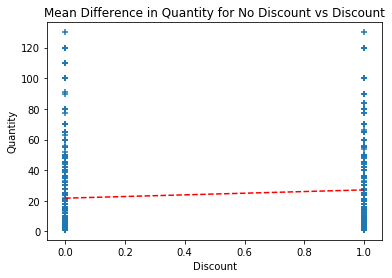

In [16]:
plt.scatter(product.DiscountBinary, product.Quantity, marker = "+")
plt.plot([0, 1], [np.mean(product.query('DiscountBinary == 0').Quantity), np.mean(product.query('DiscountBinary == 1').Quantity)], 'r--')
plt.title('Mean Difference in Quantity for No Discount vs Discount')
plt.ylabel("Quantity")
plt.xlabel("Discount")
plt.show()

In [17]:
# Contrast matrix for OLS group comparisons 

levels = [i for i in range(0, len(set(product.DiscountGrouped)))]
levels1 = [i for i in range(2)]

dummy_contrast = Treatment(reference=0).code_without_intercept(levels)
dummy_con_binary = Treatment(reference=0).code_without_intercept(levels1)

print(dummy_contrast.matrix)

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [18]:
# H0: No Discount = Discount for Quantity
# H1: No Discount != Discount for Quantity

# Robust errors used to correct for heteroscedasticity (HC3)
lm = smf.ols('Quantity ~ C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     38.88
Date:                Fri, 21 Dec 2018   Prob (F-statistic):           5.39e-10
Time:                        08:21:29   Log-Likelihood:                -9384.3
No. Observations:                2155   AIC:                         1.877e+04
Df Residuals:                    2153   BIC:                         1.878e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [19]:
# Investigation of whether all levels of discount differed significantly from no discount
lm = smf.ols('Quantity ~ C(DiscountGrouped)', data = product).fit(cov_type='HC3')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     8.408
Date:                Fri, 21 Dec 2018   Prob (F-statistic):           6.90e-08
Time:                        08:21:33   Log-Likelihood:                -9382.6
No. Observations:                2155   AIC:                         1.878e+04
Df Residuals:                    2149   BIC:                         1.881e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## INTERPRETATION

The _F-test_ evaluates the significance of $R_2$ compared to the null (nil) hypothesis, (i.e., that $R_2$ is 0). A significant F statistic indicated that the amount of variance in _Quantity_ accounted for by _Discount_ is significantly different from 0. However, $R_2$ also doubles as an effect size, indicating that ~2% of quantity can be accounted for by _some_ Discount, which isn't much. 

Interpreting the main effect of discount, the intercept $B_0$ is the mean _Quantity_ for the _no discount_ category. For the remaining groups each Beta value represents the comparison between that group and the _no discount_ group (the specified reference group). For instance, the first contrast is no discount vs 1 - 5%; $B$ = 5.3368 for this group and indicates that up to a 5% discount results in an increase in quantity of ~5. Likewise, for the second contrast, compared with no discount a 5 - 10% discount results in an increase in quantity of ~ 3. All categories of discount are significantly different from the _no discount_ category. However, this does not indicate to us that all levels of discount are significant from each other. This is a very relevant question to ask because if a 5% discount produces the same increase in Quantity for an order as a 25% discount, we could perhaps increase profits by only offering small discounts. 

**Follow up Hypotheses:**

$H_0$: **All levels of discount are equal with regards to Quantity**

$H_1$: **Levels of discount differ with regards to Quantity**


In [20]:
# Contrast only discount categories
discount = product.loc[product['DiscountGrouped'] > 0]

levels = [i for i in range(0, len(set(discount.DiscountGrouped)))]

# Compare each category to the unweighted mean of means for all others
sum_con_disc = Sum(omit=None).code_without_intercept(levels)

print('Sum Contrast Matrix for Discount Groups\n',sum_con_disc.matrix)

Sum Contrast Matrix for Discount Groups
 [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [-1. -1. -1. -1.]]


In [21]:
# OLS model to test whether level of discount was significantly related to Quantity

# See last discount category printed below summary
lm = smf.ols('Quantity ~ C(DiscountGrouped, sum_con_disc)', data = discount).fit(cov_type='HC3')
print(lm.summary(), end='\n\n')
print('C(DiscountGrouped, sum_con_disc)[S.4]     1.0797      1.450      0.745      0.457      -1.762       3.922')

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6532
Date:                Fri, 21 Dec 2018   Prob (F-statistic):              0.625
Time:                        08:21:37   Log-Likelihood:                -3729.4
No. Observations:                 838   AIC:                             7469.
Df Residuals:                     833   BIC:                             7492.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

## INTERPRETATION

A sum contrast was used to compare each level of discount with all other levels (i.e., the mean quantity for each level of discount was compared with the combined mean quantity for all other levels). Significance testing indicated that level of discount accounted for no variance/ effect in Quantity, _F = 0.65, p = 0.625_. Therefore, individual contrasts will not be investigated and we can conclude that, while some discount is significantly related to Quantity, the level of discount is inconsequential. We therefore fail to reject the null, and accept that all levels of discount are equal with regards to Quantity. 

Now, to determine whether the increase in quantity accounted for by discount is substantial in a real world sense, and not only in a statistical sense, the overall price of the sale will be investigated. Sales Price was feature engineered from **Unit Price * Quantity**, and therefore contains information about quantity as well as overall value of the sale. This may therefore be a more informative metric for decision making with regards to what discount to offer customers in the future. 

**Follow up Hypotheses:**

$H_0$: **Discount does not significantly impact Sales Price (median no discount = median discount)**

$H_1$: **Discount does significantly impact Sales Price (median no discount != median discount)**



# Sales - Discount vs No Discount

In [22]:
# Log transformed Sales were used for more reliable estimates 
lm = smf.ols('LogSales ~ C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     22.44
Date:                Fri, 21 Dec 2018   Prob (F-statistic):           2.31e-06
Time:                        08:21:44   Log-Likelihood:                -3375.0
No. Observations:                2155   AIC:                             6754.
Df Residuals:                    2153   BIC:                             6765.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [23]:
# The geometric mean is the same as the median
geo_means(product, 'DiscountBinary', 'SalePrice')

,DiscountBinary,geo_mean,median,mean
0,0.0,319.01,357.5,606.96
1,1.0,406.96,440.8,775.66


In [64]:
# The anti-log for the sum of the intercept and coefficient is the median for the Discount group (as confirmed above) 
print('Median Sales Price for Discount:', geo_mean_convert((0.2435 + 5.7652)))

# The intercept gives the geometric mean for the No Discount Group
print('Median Sales Price for No Discount:', geo_mean_convert(5.7652))

# using only the coefficient gives the ratio between geometric means
print('Ratio between median values:', geo_mean_convert(0.2435))

Median Sales Price for Discount: 406.95
Median Sales Price for No Discount: 319.0
Ratio between median values: 1.28


In [25]:
geomean_ratio(0.2435, 'no discount', 'discount')

The geometric mean of Discount is 1.28 times No Discount
The geometric mean of Discount is 28.0% more than No Discount


## INTERPRETATION

Discount significantly increased sales compared with no discount (Median = 406.95 vs Median = 319.01, respectively). Therefore, we fail to reject the null and accept that offering a discount did increase Sales. 

**Follow Up Hypotheses:**

$H_0$: **All levels of discount are equal with regards to Sales Price (Median for all discount groups equal)**

$H_1$: **Levels of discount differ with regards to Sales Price (Medians for all discount groups not equal)**



In [26]:
# Contrast only discount categories

discount = product.loc[product['DiscountGrouped'] > 0]

levels = [i for i in range(0, len(set(discount.DiscountGrouped)))]

sum_con_disc = Sum(omit=0).code_without_intercept(levels)

print(sum_con_disc.matrix)

[[-1. -1. -1. -1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [27]:
lm = smf.ols('LogSales ~ C(DiscountGrouped)', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     5.149
Date:                Fri, 21 Dec 2018   Prob (F-statistic):           0.000106
Time:                        08:30:59   Log-Likelihood:                -3373.4
No. Observations:                2155   AIC:                             6759.
Df Residuals:                    2149   BIC:                             6793.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [28]:
geo_means(product, 'DiscountGrouped', 'SalePrice')

,DiscountGrouped,geo_mean,median,mean
0,0.0,319.01,357.5,606.96
1,1.0,409.82,426.0,856.43
2,2.0,365.63,397.5,640.90
3,3.0,413.40,450.0,702.65
4,4.0,398.80,397.5,767.93
5,5.0,457.67,482.5,909.75


In [29]:
lm = smf.ols('LogSales ~ C(DiscountGrouped)', data = discount).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7741
Date:                Fri, 21 Dec 2018   Prob (F-statistic):              0.542
Time:                        08:31:00   Log-Likelihood:                -1317.6
No. Observations:                 838   AIC:                             2645.
Df Residuals:                     833   BIC:                             2669.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## INTERPRETATION

The above two analyses indicated that, on average, Sales Price was 28% higher when a discount was offered. While almost all discount groups differed significantly from no discount, the amount of discount offered did not significantly impact Sales Price (F = 0.7741, p = 0.54). Therefore, based on these analyses we can consider offering a discount of 1 - 5%. 

Discounts > 5% = 87 448.93 Euros, or 6.03% of total sales. Therefore, this could potentially be saved if smaller discounts are as effective as larger ones in increasing the number of items ordered/ overall price of the sale. 


In [ ]:
# to calculate savings figures above

#savings = product.loc[product['DiscountGrouped'] > 1]
#discounts = savings.Discount * savings.SalePrice
#(discounts.sum()/ product.SalePrice.sum()) * 100

## FOLLOW UP ANALYSES:

Before any final recommendations with regards to discount can be made, it is necessary to understand how discount may affect Sales Price for various Categories of product, Regions of Sale, or Employees. 



# CATEGORY

There are 8 categories of product. It is possible that between- and within-category effects differ from the overall effects seen in the previous analysis.  

In particular, it is important whether any interactions between category and discount exist (i.e., partialed effects - contribution to $R_2$ over and above the main effects of discount and category on Sales).

In this instance _Category_ is a fixed effect as it represents all categories of product available for this company and our conclusions apply only to these conditions of discount and category. Therefore, the interactions test the hypotheses:

$H_0$: **Discount uniformly affects Sales for all categories of product (Geo.means equal)**

$H_1$: **Discount does not uniformly affect Sales for all categories of product (Geo.means not equal)**

This analysis will help to refine our decisions regarding:
i) Whether offering discounts benefits sales
ii) What level of discount best benefits sales

Should we find that sales within certain categories are more or less affected by discount, and specific levels of discount, this will allow a more nuanced approach to discount. 

In [30]:
# Descriptives for each level of Discount and Category
print(product.groupby(['CategoryName', 'DiscountGrouped'])['SalePrice'].agg(['mean','std', 'median', min, max]).round(2))

                                   mean      std   median     min       max
CategoryName   DiscountGrouped                                             
Beverages      0.0               661.52  1750.66   252.00   13.50  15810.00
               1.0              1872.04  3478.37   438.75   36.00  15810.00
               2.0               613.27   851.77   360.00   62.00   3952.50
               3.0               455.35   381.47   360.00   36.00   1656.00
               4.0              1102.97  2841.22   325.50   45.00  13175.00
               5.0               732.34  1837.94   360.00   27.00  10540.00
Condiments     0.0               492.00   470.18   400.00   17.00   2853.50
               1.0               668.10   536.12   421.02   25.00   1945.00
               2.0               471.93   367.88   396.00   26.00   1684.00
               3.0               830.15   970.64   364.00   38.90   3512.00
               4.0               585.35   406.56   433.75   26.00   1387.75
            

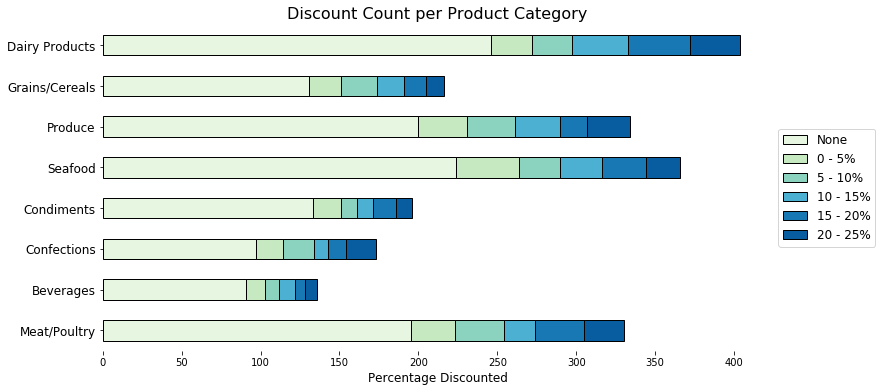

In [31]:
discount = product.groupby('CategoryName')['DiscountGrouped'].value_counts().unstack('DiscountGrouped')

discount.plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6), edgecolor = "black")

plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(np.arange(8), (['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']), fontsize=12)
plt.xlabel('Percentage Discounted', fontsize=12)
plt.legend(('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Discount Count per Product Category', fontsize=16);
sns.despine(left=True, bottom=True)

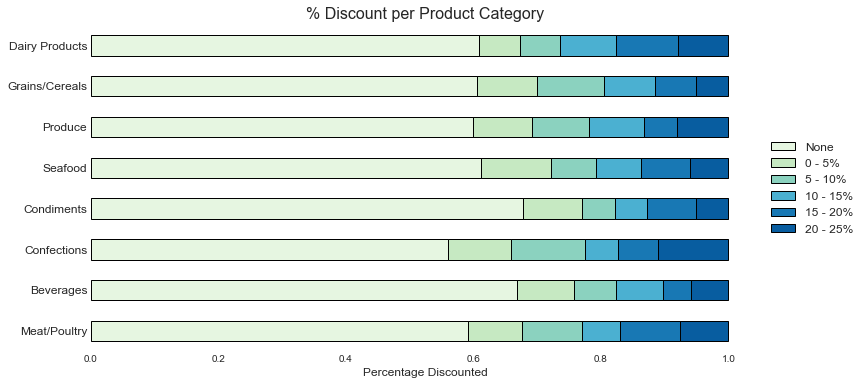

In [32]:
plt.style.use('seaborn-white')

discount = product.groupby('CategoryName')['DiscountGrouped'].value_counts(normalize=True).unstack('DiscountGrouped')

discount.plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6), edgecolor = "black")

plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(np.arange(8), (['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']), fontsize=12)
plt.xlabel('Percentage Discounted', fontsize=12)
plt.legend(('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('% Discount per Product Category', fontsize=16);
sns.despine(left=True, bottom=True)

In [56]:
levels = [i for i in range(len(set(product.CategoryId)))]
levels1 = [i for i in range(len(set(product.DiscountGrouped)))]

sum_con_cat = Sum(omit=0).code_without_intercept(levels)
dummy_con_cat = Treatment(reference=0).code_without_intercept(levels)
sum_con_disc = Sum().code_without_intercept(levels1)

print('Sum Contrast Matrix - Categories\n', sum_con_cat.matrix, end='\n\n')
print('Dummy Contrast Matrix - Categories\n', dummy_con_cat.matrix, end='\n\n')
print('Sum Contrast Matrix - Discount\n', sum_con_disc.matrix)

Sum Contrast Matrix - Categories
 [[-1. -1. -1. -1. -1. -1. -1.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]]

Dummy Contrast Matrix - Categories
 [[0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]

Sum Contrast Matrix - Discount
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [-1. -1. -1. -1. -1.]]


In [57]:
# Category sample sizes
product.groupby(['CategoryId'])['CategoryName'].value_counts()

CategoryId  CategoryName  
1           Beverages         404
2           Condiments        216
3           Confections       334
4           Dairy Products    366
5           Grains/Cereals    196
6           Meat/Poultry      173
7           Produce           136
8           Seafood           330
Name: CategoryName, dtype: int64

In [62]:
discount = product.loc[product['DiscountGrouped'] > 0]

levels = [i for i in range(0, len(set(discount.DiscountGrouped)))]

sum_con_disc = Sum(omit=4).code_without_intercept(levels)

print(sum_con_disc.matrix)

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [-1. -1. -1. -1.]]


In [63]:
lm = smf.ols('LogSales ~ C(DiscountGrouped, sum_con_disc) * C(CategoryName, sum_con_cat)', data = discount).fit()

print(lm.summary(), end='\n\n')
print('C(DiscountGrouped)[T.1.0]:C(CategoryName, sum_con_cat)[S.7]  -261.0766    138.203     -1.889      0.059    -531.950       9.797'
'C(DiscountGrouped)[T.2.0]:C(CategoryName, sum_con_cat)[S.7]   -51.0310     95.611     -0.534      0.594    -238.425     136.363'
"C(DiscountGrouped)[T.3.0]:C(CategoryName, sum_con_cat)[S.7]    75.0655    157.194      0.478      0.633    -233.029     383.160"
'C(DiscountGrouped)[T.4.0]:C(CategoryName, sum_con_cat)[S.7]   220.7109    142.485      1.549      0.121     -58.555     499.976'
'C(DiscountGrouped)[T.5.0]:C(CategoryName, sum_con_cat)[S.7]  -222.4185    139.436     -1.595      0.111    -495.708      50.871')

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.597
Date:                Fri, 21 Dec 2018   Prob (F-statistic):             0.0127
Time:                        09:55:01   Log-Likelihood:                -1287.7
No. Observations:                 838   AIC:                             2655.
Df Residuals:                     798   BIC:                             2845.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [39]:
# The intercept gives the unweighted geometric mean for the No Discount Group conditioned on every category
print('Sales Price for unweighted Geo. Mean of No Discount for all categories:', geo_mean_convert(5.8231))

# The anti-log for the Beverages * 1-5% discount interaction 
print('Sales Price for Beverages * 1-5% discount:', geo_mean_convert((0.5698 + 5.8231)))

# The anti-log for the Confections * 10-15% discount interaction 
print('Sales Price for Confections * 10-15% discount:', geo_mean_convert((0.0080 + 5.8231)))


# using only the coefficient gives the ratio between geometric means
print(':', geo_mean_convert(0.5698))

# using only the coefficient gives the ratio between geometric means
print('Ratio between median values:', geo_mean_convert(0.0080))

Sales Price for unweighted Geo. Mean of No Discount for all categories: 338.02
Median Sales Price for Discount: 597.59
Median Sales Price for Discount: 340.73
Ratio between median values: 1.77
Ratio between median values: 1.01


In [47]:
geomean_ratio(0.5698, 'No Discount all categories', 'Beverages discount 1 - 5%')

The geometric mean of Beverages Discount 1 - 5% is 1.77 times No Discount All Categories
The geometric mean of Beverages Discount 1 - 5% is 77.0% more than No Discount All Categories


In [46]:
geomean_ratio(0.0080, 'No Discount all categories', 'Confections discount 10 - 15%')

The geometric mean of Confections Discount 10 - 15% is 1.01 times No Discount All Categories
The geometric mean of Confections Discount 10 - 15% is 1.0% more than No Discount All Categories


## INTERPRETATION

Overall the model was significant, F = 6.335, p = 2.44e-13. However, only the interaction effects are of interest for addressing the current hypotheses. The categories that had significant interactions with discount were _Beverages_ and  _Confections_. 

These interactions was followed up with a more detailed analysis of the levels of discount that may be responsible for the observed difference. Each level of discount was compared with the no discount condition to test the null hypothesis:

%H_0%: **Discount has no relationship to Confection Sales**

%H_1%: **Discount has a relationship to Confection Sales**

Below is a selection of the analysis for Confections, as all other interactions were non significant. 

## Comparisons to No Discount
```
OLS Regression Results                            
==============================================================================
Dep. Variable:               LogSales   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.961
Date:                Fri, 21 Dec 2018   Prob (F-statistic):           1.29e-10
Time:                        09:14:07   Log-Likelihood:                -3317.4
No. Observations:                2155   AIC:                             6731.
Df Residuals:                    2107   BIC:                             7003.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       5.8231      0.033    173.956      0.000       5.757       5.889
C(DiscountGrouped)[T.1.0]                                       0.2055      0.094      2.187      0.029       0.021       0.390
C(DiscountGrouped)[T.2.0]                                       0.1729      0.101      1.708      0.088      -0.026       0.371
C(DiscountGrouped)[T.3.0]                                       0.2580      0.108      2.384      0.017       0.046       0.470
C(DiscountGrouped)[T.4.0]                                       0.1656      0.111      1.495      0.135      -0.052       0.383
C(DiscountGrouped)[T.5.0]                                       0.3906      0.108      3.604      0.000       0.178       0.603
C(CategoryName, sum_con_cat)[S.0]                              -0.2856      0.071     -4.004      0.000      -0.426      -0.146
C(CategoryName, sum_con_cat)[S.1]                              -0.0140      0.093     -0.151      0.880      -0.196       0.168
C(CategoryName, sum_con_cat)[S.2]                              -0.0338      0.077     -0.436      0.663      -0.186       0.118
C(CategoryName, sum_con_cat)[S.3]                               0.0900      0.074      1.216      0.224      -0.055       0.235
C(CategoryName, sum_con_cat)[S.4]                              -0.1211      0.092     -1.316      0.188      -0.301       0.059
C(CategoryName, sum_con_cat)[S.5]                               0.3022      0.106      2.858      0.004       0.095       0.510
C(CategoryName, sum_con_cat)[S.6]                               0.4127      0.109      3.792      0.000       0.199       0.626

C(DiscountGrouped)[T.1.0]:C(CategoryName, sum_con_cat)[S.0]     0.5698      0.224      2.540      0.011*      0.130       1.010
C(DiscountGrouped)[T.2.0]:C(CategoryName, sum_con_cat)[S.0]     0.1335      0.231      0.578      0.563      -0.319       0.586
C(DiscountGrouped)[T.3.0]:C(CategoryName, sum_con_cat)[S.0]    -0.1079      0.207     -0.522      0.602      -0.514       0.298
C(DiscountGrouped)[T.4.0]:C(CategoryName, sum_con_cat)[S.0]     0.1979      0.203      0.974      0.330      -0.200       0.596
C(DiscountGrouped)[T.5.0]:C(CategoryName, sum_con_cat)[S.0]    -0.2693      0.215     -1.253      0.210      -0.691       0.152

C(DiscountGrouped)[T.1.0]:C(CategoryName, sum_con_cat)[S.2]    -0.0364      0.213     -0.171      0.864      -0.453       0.380
C(DiscountGrouped)[T.2.0]:C(CategoryName, sum_con_cat)[S.2]    -0.4624      0.218     -2.118      0.034*     -0.891      -0.034
C(DiscountGrouped)[T.3.0]:C(CategoryName, sum_con_cat)[S.2]     0.0080      0.224      0.036      0.972      -0.432       0.448
C(DiscountGrouped)[T.4.0]:C(CategoryName, sum_con_cat)[S.2]    -0.4280      0.273     -1.567      0.117      -0.963       0.108
C(DiscountGrouped)[T.5.0]:C(CategoryName, sum_con_cat)[S.2]    -0.1195      0.230     -0.520      0.603      -0.570       0.331

C(DiscountGrouped)[T.1.0]:C(CategoryName, sum_con_cat)[S.7]    -0.1117      0.221     -0.506      0.613      -0.544       0.321
C(DiscountGrouped)[T.2.0]:C(CategoryName, sum_con_cat)[S.7]    -0.0443      0.216     -0.205      0.838      -0.468       0.380
C(DiscountGrouped)[T.3.0]:C(CategoryName, sum_con_cat)[S.7]     0.2250      0.256      0.879      0.379      -0.277       0.727
C(DiscountGrouped)[T.4.0]:C(CategoryName, sum_con_cat)[S.7]     0.4709      0.221      2.133      0.033*      0.038       0.904
C(DiscountGrouped)[T.5.0]:C(CategoryName, sum_con_cat)[S.7]    -0.2023      0.236     -0.856      0.392      -0.665       0.261

-------------------------------------------------------------------------------------------------------------------------------
```



## Comparisons between All discount levels

```
                OLS Regression Results                            
==============================================================================
Dep. Variable:               LogSales   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.961
Date:                Fri, 21 Dec 2018   Prob (F-statistic):           1.29e-10
Time:                        09:15:26   Log-Likelihood:                -3317.4
No. Observations:                2155   AIC:                             6731.
Df Residuals:                    2107   BIC:                             7003.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     6.0219      0.037    161.094      0.000       5.949       6.095
C(DiscountGrouped)[S.1]                                       0.0068      0.081      0.084      0.933      -0.152       0.165
C(DiscountGrouped)[S.2]                                      -0.0259      0.086     -0.299      0.765      -0.195       0.144
C(DiscountGrouped)[S.3]                                       0.0592      0.092      0.644      0.520      -0.121       0.240
C(DiscountGrouped)[S.4]                                      -0.0332      0.094     -0.353      0.724      -0.217       0.151
C(DiscountGrouped)[S.5]                                       0.1918      0.092      2.083      0.037       0.011       0.372
C(CategoryName)[S.0]                                         -0.1983      0.077     -2.575      0.010      -0.349      -0.047
C(CategoryName)[S.1]                                          0.0405      0.101      0.403      0.687      -0.157       0.238
C(CategoryName)[S.2]                                         -0.2068      0.083     -2.500      0.013      -0.369      -0.045
C(CategoryName)[S.3]                                          0.1649      0.081      2.048      0.041       0.007       0.323
C(CategoryName)[S.4]                                         -0.0798      0.114     -0.698      0.485      -0.304       0.144
C(CategoryName)[S.5]                                          0.2998      0.107      2.792      0.005       0.089       0.510
C(CategoryName)[S.6]                                          0.2739      0.133      2.065      0.039       0.014       0.534

C(DiscountGrouped)[S.1]:C(CategoryName)[S.0]                  0.4825      0.190      2.539      0.011*      0.110       0.855
C(DiscountGrouped)[S.2]:C(CategoryName)[S.0]                  0.0461      0.195      0.236      0.813      -0.336       0.429
C(DiscountGrouped)[S.3]:C(CategoryName)[S.0]                 -0.1952      0.176     -1.108      0.268      -0.541       0.150
C(DiscountGrouped)[S.4]:C(CategoryName)[S.0]                  0.1106      0.173      0.638      0.524      -0.229       0.450
C(DiscountGrouped)[S.5]:C(CategoryName)[S.0]                 -0.3566      0.183     -1.953      0.051      -0.715       0.001

C(DiscountGrouped)[S.1]:C(CategoryName)[S.5]                 -0.0564      0.234     -0.241      0.810      -0.516       0.403
C(DiscountGrouped)[S.2]:C(CategoryName)[S.5]                  0.1673      0.224      0.747      0.455      -0.272       0.606
C(DiscountGrouped)[S.3]:C(CategoryName)[S.5]                  0.0944      0.301      0.313      0.754      -0.497       0.686
C(DiscountGrouped)[S.4]:C(CategoryName)[S.5]                 -0.6651      0.279     -2.380      0.017*     -1.213      -0.117
C(DiscountGrouped)[S.5]:C(CategoryName)[S.5]                  0.4573      0.230      1.989      0.047*      0.006       0.908

C(DiscountGrouped)[S.0]:C(CategoryName)[S.7]                 -0.0563      0.104     -0.542      0.588      -0.260       0.147
C(DiscountGrouped)[S.1]:C(CategoryName)[S.7]                 -0.1679      0.187     -0.897      0.370      -0.535       0.199
C(DiscountGrouped)[S.2]:C(CategoryName)[S.7]                 -0.1006      0.184     -0.547      0.584      -0.461       0.260
C(DiscountGrouped)[S.3]:C(CategoryName)[S.7]                  0.1688      0.215      0.784      0.433      -0.253       0.591
C(DiscountGrouped)[S.4]:C(CategoryName)[S.7]                  0.4146      0.187      2.213      0.027*      0.047       0.782
```

## Within-Discount
```
OLS Regression Results                            
==============================================================================
Dep. Variable:               LogSales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.597
Date:                Fri, 21 Dec 2018   Prob (F-statistic):             0.0127
Time:                        09:41:08   Log-Likelihood:                -1287.7
No. Observations:                 838   AIC:                             2655.
Df Residuals:                     798   BIC:                             2845.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                  6.0616      0.045    135.240      0.000       5.974       6.150

C(DiscountGrouped)[S.0]:C(CategoryName)[S.5]              -0.0559      0.237     -0.235      0.814      -0.522       0.410
C(DiscountGrouped)[S.1]:C(CategoryName)[S.5]               0.1678      0.228      0.736      0.462      -0.280       0.615
C(DiscountGrouped)[S.2]:C(CategoryName)[S.5]               0.0949      0.299      0.317      0.751      -0.492       0.682
C(DiscountGrouped)[S.3]:C(CategoryName)[S.5]              wa-0.6646      0.279     -2.384      0.017      -1.212      -0.117




C(DiscountGrouped)[S.0]:C(CategoryName)[S.7]              -0.1792      0.189     -0.949      0.343      -0.550       0.192
C(DiscountGrouped)[S.1]:C(CategoryName)[S.7]              -0.1118      0.186     -0.602      0.547      -0.476       0.253
C(DiscountGrouped)[S.2]:C(CategoryName)[S.7]               0.1575      0.214      0.735      0.463      -0.263       0.578
C(DiscountGrouped)[S.3]:C(CategoryName)[S.7]               0.4034      0.189      2.134      0.033       0.032       0.774
C(DiscountGrouped)[S.4]:C(CategoryName)[S.7]              -0.2698      0.200     -1.349      0.178      -0.662       0.123







## INTERPRETATION

Discounts between 5 - 10% and 15 - 20% were related to significantly less sales for Confections, and between 10-15% were related to significantly less sales for Beverages. To understand the coefficient within the regression equation:

-------------------------------------------------------------------------------------------------------------------------------
EXAMPLE
The regression equation for the 5-10% discount condition on Confections:
Y = B0 + B1*X + B2*X + B3*X, 

where B0 (Intercept) = 628.25, B1(Category Main Effect) = -50.72, B2(Discount Main Effect) = 70.36, 
      B3(Category*Discount Interaction for 5 - 10%) = -253.67
      

The mean difference between Confections and all other categories is B0 + B1: 628.2459 + (-50.7218) = 577.5241
The mean difference in 5-10% vs no discount comparison for all categories is (B0 + B1) + B2: 577.5241 + 70.3624 = 647.8865

The mean for 5 - 10% discount for Confections is (B0 + B1 + B2) + B3: 647.8865 + (-253.6721) = 394.21 (see descriptives above above). 

-------------------------------------------------------------------------------------------------------------------------------

_Relative_ to other categories, Confections were more likely to have reduced sales when discounts of either 5-10% and 15-20% were offered. The 20-25% category of discount was not significant, but had a similar trend towards significance and reduced sales. No overall (main effect) difference was found for Confection Sales compared with all other product categories, z = -0.995, p = 0.320.  

Despite higher sales within Confections for the 20 - 25% bracket, when this category is compared with other categories for this level of discount there is a relative reduction in Sales of 279.29 Euro. Likewise, when compared with all other categories, there was a relative reduction in sales for the other two discount categories.   

## Within-Groups Tests

For each Category a within-groups test was carried out for Discount vs No Discount (to contrast with the previous between-groups analysis). No significant differences were found within groups, indicating that the effects were too small to be detected (less than 0.2 for most groups and less than 0.3 for Grains/Cereal, Meat/Poultry, and Produce). 

Beverages: F = 1.715, p = 0.130, B = 0.88 (for an effect size 0.2 and greater)
Condiments: F = 1.289, p = 0.270, B = 0.82 (for an effect size 0.25 and greater)      
Confections: F = 1.876, p = 0.10, B = 0.81 (for an effect size 0.2 and greater)        
Dairy Products: F = 1.404, p = 0.222, B = 0.85 (for an effect size 0.2 and greater)
Grains/Cereals: F = 0.406, p = 0.845, B = 0.91 (for an effect size 0.3 and greater)*
Meat/Poultry: F = 1.932, p = 0.10, B = 0.86 (for an effect size 0.3 and greater)*
Produce: F = 0.33, p = 0.89, B = 0.76 (for an effect size 0.3 and greater)**
Seafood: F = 1.488, p = 0.19, B = 0.81 (for an effect size 0.2 and greater)


## INTERPRETATION

In conclusion then, while Sales significantly increased for Discount compared with No Discount, the effect size for this increase was small. All Product Categories were uniform with regards to this effect, except for Confections and Grains). Therefore we fail to reject the null that all Categories are uniformly affected by Discount.

The figure below illustrates that a number of Categories had higher mean Sales for Discount; however, these differences failed to reach significance due to _inconsistently_ large Sales for higher discounts and high Sales where Discounts were not offered. Therefore, Discount is not consistently being used to increase Sales and in the case of Confections, seems to be leading to significantly reduced Sales overall.  

For the most part, the level of discount offered did not appear to increase Sales for any one category. My suggestion based on this is to keep discount to a minimum level across all Categories and to perhaps to use Discounts more strategically. 

In [ ]:
product.SalePrice.agg('median')

In [ ]:
NUM_COLORS = 8

cm = pylab.get_cmap('plasma')
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple

# or if you really want a generator:
cgen = list((cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)))

sns.set(style="white")
fig = plt.figure(figsize=(7,7))
ax = fig.gca()

interaction_plot(product.DiscountBinary, product.CategoryName, product.LogSales,
             colors=cgen, markers=['D','^', 'o', 'o', 'D', '^', 'o', 'D'], ms=8, ax=ax)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Mean Sales', fontsize=12)
plt.xlabel('No Discount vs Discount', fontsize=12)
plt.title('Discount per Category', fontsize=14);

## Outliers

The figure below indicates that outliers may be skewing the results. So a model was run with only Sales below 6000 Euros. However, this analysis gave the same general result. 

In [ ]:
boxplot(product, 'CategoryName', 'LogSales', 'Categories', 'Sales', 'Sales per Category')

In [ ]:
sales = product.loc[product['SalePrice'] < 6000]

In [ ]:
boxplot(sales, 'CategoryName', 'SalePrice', 'Categories', 'Sales', 'Sales per Category')

In [ ]:
# Between-Groups Analysis of Category and Discount with Sales below 6000 Euro
lm = smf.ols('SalePrice ~ C(CategoryId, sum_con_cat) * C(DiscountBinary)', data = sales).fit(cov_type='HC3')
print(lm.summary())

# Region

There are 9 Shipping Regions. It is possible that between-groups effects differ from the overall effects seen in the original analysis.  

In particular, it is important whether any interactions between Region and Discount exist. 

In this instance _ShipRegion_ is a fixed effect as it represents all regions available for this company and our conclusions apply only to these conditions of discount and region. Therefore, the interactions test the hypotheses:

$H_0$: **Discount uniformly affects Regions for all categories of product**

$H_1$: **Discount does not uniformly affect Regions for all categories of product**

This analysis will help to refine our decisions regarding:
i) Whether offering discounts benefits sales
ii) What level of discount best benefits sales


In [ ]:
product.groupby(['ShipRegion'])['SalePrice'].mean()

In [ ]:
# Does Discount vary significantly by Region?
levels = [i for i in range(len(set(product.ShipRegion)))]

sum_con_ship = Sum().code_without_intercept(levels)

print(sum_contrast.matrix)

In [ ]:
lm = smf.ols('LogSales ~ C(ShipRegion, sum_con_ship) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
NUM_COLORS = 9

cm = pylab.get_cmap('plasma')
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple

# or if you really want a generator:
cgen = list((cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)))



sns.set(style="white")
fig = plt.figure(figsize=(7,7))
ax = fig.gca()

interaction_plot(product.DiscountBinary, product.ShipRegion, product.SalePrice,
             colors=cgen, markers=['D','^', 'o', 'o', 'D', '^', 'o', 'D', '^'], ms=8, ax=ax)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Mean Sales', fontsize=12)
plt.xlabel('No Discount vs Discount', fontsize=12)
plt.title('Discount per Category', fontsize=14);

## INTERPRETATION

Using log transformed Sales Price to correct for skew, 

In [ ]:
lm = smf.ols('SalePrice ~ C(EmployeeId, sum_con_emp)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
lm = smf.ols('SalePrice ~ C(EmployeeId, sum_con_emp) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
lm = smf.ols('LogSales ~ C(EmployeeId, sum_con_emp) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
lm = smf.ols('LogSales ~ C(EmployeeId, sum_con_emp)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
employee_contrast = product.loc[product['EmployeeId'] == 8]

In [ ]:
product['SalesRatio'] = product.ExtendedPrice/product.SalePrice
product['DiscountAmount'] = product.Discount * product.SalePrice

In [ ]:
product.DiscountAmount.hist()

In [ ]:
product.DiscountAmount.describe()

In [ ]:
product.groupby('EmployeeId')['SalesRatio'].mean()

In [ ]:
len(employee_contrast)
employee_contrast.groupby('DiscountGrouped')['SalePrice'].mean().plot();

In [ ]:
product.groupby('DiscountGrouped')['SalePrice'].median().plot()

In [ ]:
levels = [i for i in range(len(set(employee_contrast.CategoryId)))]

sum_con = Sum().code_without_intercept(levels)

print(sum_contrast.matrix)

In [ ]:
lm = smf.ols('SalePrice ~ C(DiscountBinary) * C(CategoryId, sum_con)', data = employee_contrast).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
product.groupby(['EmployeeId', 'DiscountBinary'])['Quantity', 'SalePrice'].mean()

In [ ]:
product['Sale_z'] = (product['SalePrice'] - product['SalePrice'].mean())/ product.SalePrice.std()

In [ ]:
z_hbar(product, 'EmployeeId', 'Sale_z', 'Employee Sales', 'Employee Sales Standardized')

In [ ]:
z_hbar(product, 'EmployeeId', 'SalePrice', 'Employee Sales', 'Employee Sales')

In [ ]:
levels = [i for i in range(len(set(product.ShipRegion)))]

sum_con_ship = Sum().code_without_intercept(levels)

print(sum_contrast.matrix)

In [ ]:
lm2 = smf.ols('LogQuantity ~ C(ShipRegion, sum_con_ship) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
test_class = OLSInfluence(lm2)
influence = test_class.summary_frame()
influence.standard_resid.hist()

In [ ]:
lm = smf.ols('LogSales ~ C(ShipRegion, sum_con_ship) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
product.groupby('ShipRegion')['SalePrice', 'Quantity', 'Freight'].mean().round(2)

In [ ]:
lm = smf.ols('Freight ~ C(ShipRegion) * ', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
sns.distplot(OLSResults.resid(new));
OLSResults.resid(new).mean()

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
test_class = OLSInfluence(lm)
test_class.dfbetas[:5,:]

In [ ]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(lm, ax = ax)

In [ ]:
dir(test_class);

In [ ]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(lm.resid, lm.model.exog)
list(zip(name, test))

In [ ]:
product.Quantity[1363]
product.Quantity[1621]

In [ ]:
lm = smf.ols('ExtendedPrice ~ Quantity', data = product).fit()
print(lm.summary())

In [ ]:
lm = smf.ols('Quantity ~ OrderPrice', data = product).fit()
print(lm.summary())

In [ ]:
product.head()

In [ ]:
from patsy.contrasts import Treatment

levels = [1,2,3,4,5,6]

contrast = Treatment(reference=0).code_without_intercept(levels)

print(contrast.matrix)

In [ ]:
lm = smf.ols('Quantity ~ C(DiscountGrouped, contrast)', data = product).fit()
print(lm.summary())

In [ ]:
len(product.CategoryId.unique())

In [ ]:
from patsy.contrasts import Helmert

helmert = Helmert().code_without_intercept(levels)

print(helmert.matrix)

In [ ]:
lm = smf.ols('Quantity ~ C(DiscountGrouped, contrast)', data = product).fit()
print(lm.summary())

In [ ]:
effect_size = 0.4
alpha = 0.05 # significance level
power = 0.8

power_analysis = FTestAnovaPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size: {0:.2f}'.format(sample_size))

In [ ]:
smp.FTestPower().solve_power(effect_size=0.1, df_num=2147, df_denom=7, alpha=0.05)

In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
import cufflinks as cf
import plotly.offline as py

cf.go_offline() # required to use plotly offline (no account required).
py.init_notebook_mode() # graphs charts inline (IPython).

### REFERENCES 

https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/

https://stats.stackexchange.com/questions/163518/interpreting-test-results-on-log-transformed-data

http://www.jerrydallal.com/LHSP/ci_logs.htm

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/

https://blog.stata.com/2011/08/22/use-poisson-rather-than-regress-tell-a-friend/

https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va/3530#3530

Cohen (2013). Applied Multiple Regression/Correlation Analysis for the Behavioral Sciences. 

Further investigation before final decision:
1) Is the effect of discount on Quantity or Sales Price modulated by time? In other words, does offering larger discounts earlier on result in more sales over time for any customers? 